In [1]:
# Import Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [2]:
# Define Functions
def get_missing_ages(titanic_df):
    """
    Returns a DataFrame with the rows where Age is missing.
    Uses regression to predict missing ages based on other features.

    Parameters:
    titanic_df: DataFrame containing Titanic passenger data with missing Age values.

    Returns:
    DataFrame with missing Age values filled in using regression.
    """
    # Prepare the data for regression, using list of features that are likely to influence Age
    # Create a DataFrame with known and missing ages, known ages for training and missing ages for prediction
    features = ["Sex", "Pclass", "SibSp", "Parch", "Fare"]
    known_age_df = titanic_df[titanic_df["Age"].notnull()]
    missing_age_df = titanic_df[titanic_df["Age"].isnull()]

    # Convert categorical variables to numerical using one-hot encoding
    X_known = pd.get_dummies(known_age_df[features], drop_first=True)
    y_known = known_age_df["Age"]
    X_missing = pd.get_dummies(missing_age_df[features], drop_first=True)

    # Align columns in both data sets in case get_dummies creates different columns
    X_missing = X_missing.reindex(columns=X_known.columns, fill_value=0)

    # Train the model using fit method
    model = LinearRegression()
    model.fit(X_known, y_known)

    # Predict missing ages useing trained model, and put age back into the DataFrame
    if not X_missing.empty:
        predicted_ages = model.predict(X_missing)
        titanic_df.loc[missing_age_df.index, "Age"] = predicted_ages

    # Convert Age to float type, as it may have been inferred as object type due to missing values
    titanic_df["Age"] = titanic_df["Age"].astype(float).round(1)
    return titanic_df


def annotate_percentages(ax, data, x_col):
    """
    Annotate the bars in a countplot with the percentage of each category.
    Parameters:
    ax: The axes object of the countplot.
    data: The DataFrame containing the data.
    x_col: The column name for the x-axis (the categorical variable).
    """
    # Calculate total counts for each category
    total_counts = data.groupby(x_col).size()
    tick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        if height == 0:
            continue  # Skip annotation for bars with height 0
        # There are len(tick_labels) bars per hue, so use modulo to get the correct label
        label_idx = i % len(tick_labels)
        cat_label = tick_labels[label_idx]
        if cat_label in total_counts:
            total = total_counts[cat_label]
            percentage = f"{100 * height / total:.1f}%"
            ax.annotate(
                percentage,
                (p.get_x() + p.get_width() / 2, height),
                ha="center",
                va="bottom",
            )

Guidance for our EDA is:
What is the most important factor in determining whether a person was likely to survive the sinking of the Titanic?
In the movie, the upper-class passengers were given preference on lifeboats. Does this show in the data?
“Women and children first”. Was this the case?
Add one other observation that you have noted in the dataset.

In [3]:
titanic_df = pd.read_csv("Titanic.csv")
print(titanic_df.head())
print(titanic_df.shape)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
(8

In [4]:
# Check for missing values
missing_values_count = titanic_df.isnull().sum()
print(missing_values_count[0:12])

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


We see we are missing values in the Age (177/891), Cabin(687/891), and Embarked (2/891) columns.

In [5]:
# Course of Action #1. Cabin: We will drop this column as it has too many missing values.
titanic_df = titanic_df.drop(columns=["Cabin"])

# Course of Action #2. Embarked: We will fill in the missing values with the most common port of embarkation.
titanic_df["Embarked"] = titanic_df["Embarked"].fillna(titanic_df["Embarked"].mode()[0])

# Course of Action #3. Age is important for survival prediction, so we will fill 
# in the missing values using regression, in the get_missing_ages function.
titanic_df = get_missing_ages(titanic_df)

In [6]:
# Check if there are still missing values
missing_values_count = titanic_df.isnull().sum()
print(missing_values_count[0:12])


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


Successfully filled in the missing values, now to the EDA. As our exploration is geared towards survival prediction, we test each of the columns against the Survived column

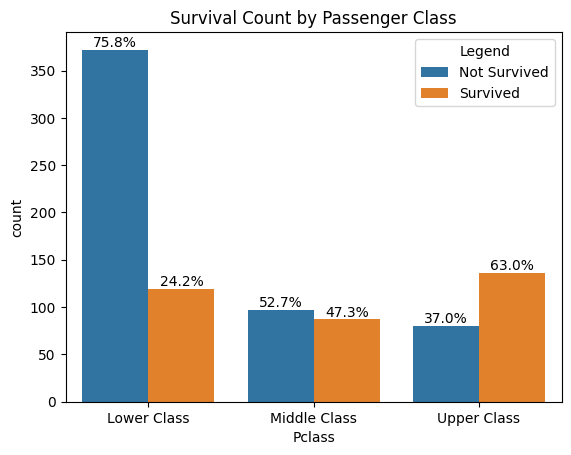

In [7]:
# Survived vs Pclass
titanic_df["Pclass"] = titanic_df["Pclass"].map(
    {1: "Upper Class", 2: "Middle Class", 3: "Lower Class"}
)
ax = sns.countplot(
    x="Pclass",
    hue="Survived",
    data=titanic_df,
    order=["Lower Class", "Middle Class", "Upper Class"],
)

plt.title("Survival Count by Passenger Class")
annotate_percentages(ax, titanic_df, "Pclass")

# Continue with legend and show
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Not Survived", "Survived"], title="Legend")
plt.show()

From this plot, we can see that the upper class had a higher survival rate compared to the middle and lower classes. It was the only class where more people survived than did not survive. Lower class passengers had the lowest survival rate, and middle class passengers had a survival rate between the two. There is clearly some correlation between a higher class, and chance of survival.

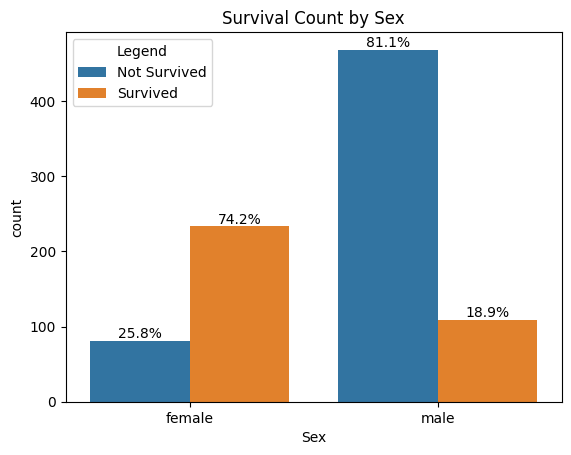

In [8]:
# Survived vs Sex
ax = sns.countplot(
    x="Sex",
    hue="Survived",
    data=titanic_df,
    order=["female", "male"],
)
plt.title("Survival Count by Sex")
annotate_percentages(ax, titanic_df, "Sex")
# Edit legend labels for clarity
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Not Survived", "Survived"], title="Legend")
plt.show()

From this plot, we see that far more women survived than men, and that more women survived than did not survive by a considerable amount. On the other hand, far more men died than survived. This supports ideas that women were given preference in lifeboats over men.

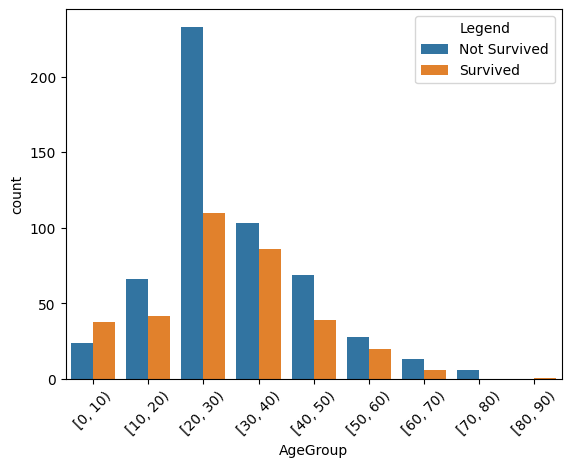

In [9]:
# Survived vs Age
# Create age bins in 5-year intervals
age_bins = range(0, int(titanic_df["Age"].max()) + 11, 10)
titanic_df["AgeGroup"] = pd.cut(titanic_df["Age"], bins=age_bins, right=False)

# Plot survival count by age group
ax = sns.countplot(x="AgeGroup", hue="Survived", data=titanic_df)
plt.xticks(rotation=45)
# Edit legend labels for clarity
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Not Survived", "Survived"], title="Legend")
plt.show()

We can see that the survival rate is highest for children and young adults, and decreases with age. 0-10 years is the only age group with a positive survival rate. The survival rate for the oldest age group is very low, which may be due to the fact that older passengers were less able to move to the lifeboats without assistance. The age group of 20-30 is the lowest survival rate, which could indicate some correlation between age and class.

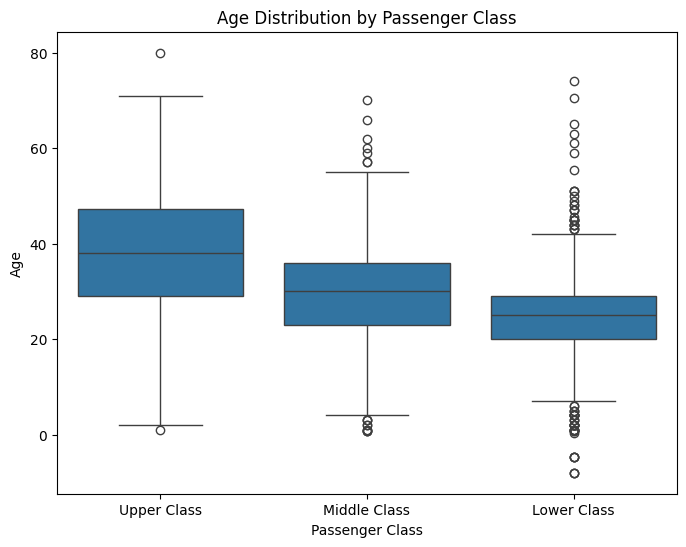

Mean Age by Passenger Class:
Pclass
Lower Class     24.927902
Middle Class    30.165217
Upper Class     38.425463
Name: Age, dtype: float64

Median Age by Passenger Class:
Pclass
Lower Class     25.1
Middle Class    30.0
Upper Class     38.0
Name: Age, dtype: float64


In [10]:
# Boxplot: Age distribution by Passenger Class
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="Pclass",
    y="Age",
    data=titanic_df,
    order=["Upper Class", "Middle Class", "Lower Class"],
)
plt.title("Age Distribution by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Age")
plt.show()

mean_ages = titanic_df.groupby("Pclass")["Age"].mean()
median_ages = titanic_df.groupby("Pclass")["Age"].median()
print("Mean Age by Passenger Class:")
print(mean_ages)
print("\nMedian Age by Passenger Class:")
print(median_ages)

From the boxplot and the mean + median information, we can see that most of the people netween 20 - 30 years were in the bottom two classes, which lends strong credibility to the correlation between class and age, and that the effect that class had on surviviability could be a product of the age of the passengers.

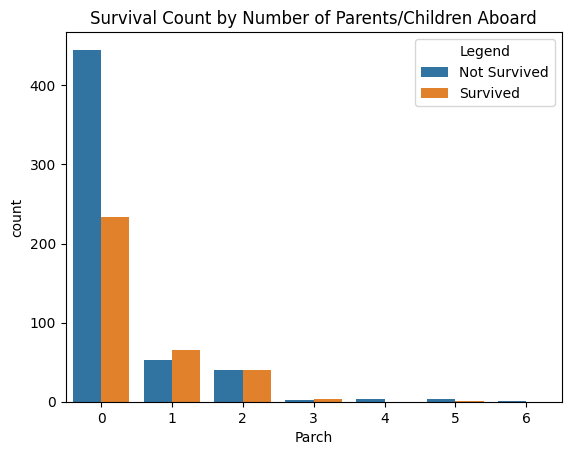

In [11]:
# Survived vs Parch
ax = sns.countplot(x="Parch", hue="Survived", data=titanic_df)
plt.title("Survival Count by Number of Parents/Children Aboard")
# Edit legend labels for clarity
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Not Survived", "Survived"], title="Legend")
plt.show()

We can see that passengers with no parents or children aboard had the lowest survival rate. Passengers with 1 parent or child had the highest survival rate (and only positive survival rate), and those with 2 or more had a survival rate between the two (almost 50/50). This may be due to passengers with parents or children aboard being given preference in lifeboats.

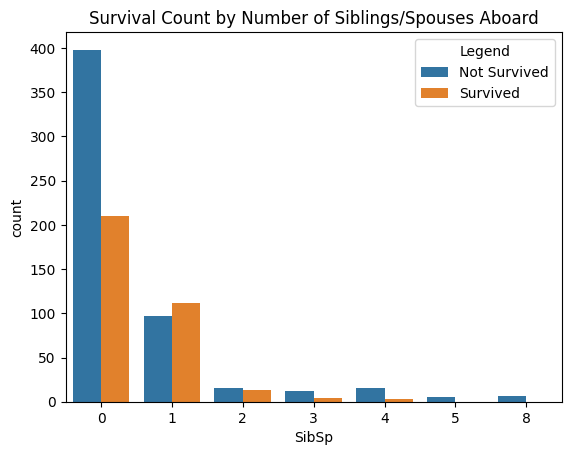

In [12]:
# Survived vs SibSp
ax = sns.countplot(x="SibSp", hue="Survived", data=titanic_df)
plt.title("Survival Count by Number of Siblings/Spouses Aboard")
# Edit legend labels for clarity
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Not Survived", "Survived"], title="Legend")
plt.show()

This plot is very similar to the Parch vs Survival, as people with 1 or 2 Siblings or Spouses aboard were the most likely to survive.

After this inital search, it's clear that a lot of the variables have influence on survival rate. I think it's best to look at some stacked bar charts, comparing the percentages of each variable in the surviving population against the total population. If the surviving population has different proportions than the total population, then we know that those variables were key in survival rate.

Please note - as the stacked bar chart is used repeatedly, I am fully annotating the first use below, and restrictively annotating the others, noting the key differences when I am adjusting the program for various reasons.

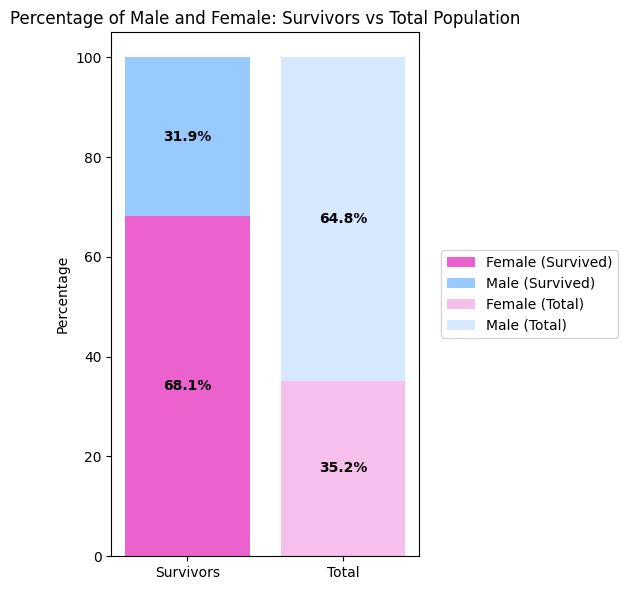

In [13]:
# SEX DISPROPRTION IN SURVIVORS

# Percentage of total survivors by sex (stacked bar chart)
survivors = titanic_df[titanic_df["Survived"] == 1]
sex_counts_surv = survivors["Sex"].value_counts()
total_survivors = sex_counts_surv.sum()
percentages_surv = (sex_counts_surv / total_survivors * 100).round(1)
values_surv = [percentages_surv.get("female", 0), percentages_surv.get("male", 0)]

# Percentage of total population by sex
sex_counts_total = titanic_df["Sex"].value_counts()
total_population = sex_counts_total.sum()
percentages_total = (sex_counts_total / total_population * 100).round(1)
values_total = [percentages_total.get("female", 0), percentages_total.get("male", 0)]

# Figure creation
fig, ax = plt.subplots(figsize=(6, 6))

# Stacked bar for survivors
ax.bar("Survivors", values_surv[0], label="Female (Survived)", color="#eb61cd")
ax.bar(
    "Survivors",        # Index for survivors bar
    values_surv[1],     # Percentage of male survivors
    bottom=values_surv[0],  # Stack on top 
    label="Male (Survived)",    # Label for legend
    color="#99caff",    # Colour selection
)

# Stacked bar for total population (faded for visual effect)
ax.bar("Total", values_total[0], label="Female (Total)", color="#eb61cd", alpha=0.4)
ax.bar(
    "Total",
    values_total[1],
    bottom=values_total[0],
    label="Male (Total)",
    color="#99caff",
    alpha=0.4,
)

# Labelling axes and moving legend out of the way of graph
ax.set_ylabel("Percentage")
ax.set_title("Percentage of Male and Female: Survivors vs Total Population")
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

# Put the percentages on the bars
for index, value in enumerate(values_surv):
    ax.text(
        0,  # Survivor population bar index
        sum(values_surv[:index]) + value / 2,   # Calculate the position for the text
        f"{value:.1f}%",    # Percentage text to 1 decimal place
        ha="center",        # horizontal alignment
        va="center",        # vertical alignment
        color="black",      # text color
        fontweight="bold",  # text weight
    )
for index, value in enumerate(values_total):
    ax.text(
        1,  # Total population bar index
        sum(values_total[:index]) + value / 2,
        f"{value:.1f}%",
        ha="center",
        va="center",
        color="black",
        fontweight="bold",
    )
plt.tight_layout()
plt.show()

This shows that whilst the total population was only 35.2% female, the percentage of the surviving population was 68.1% female - a 93.5% increase that shows qutie explicitly that women were given preference over men.

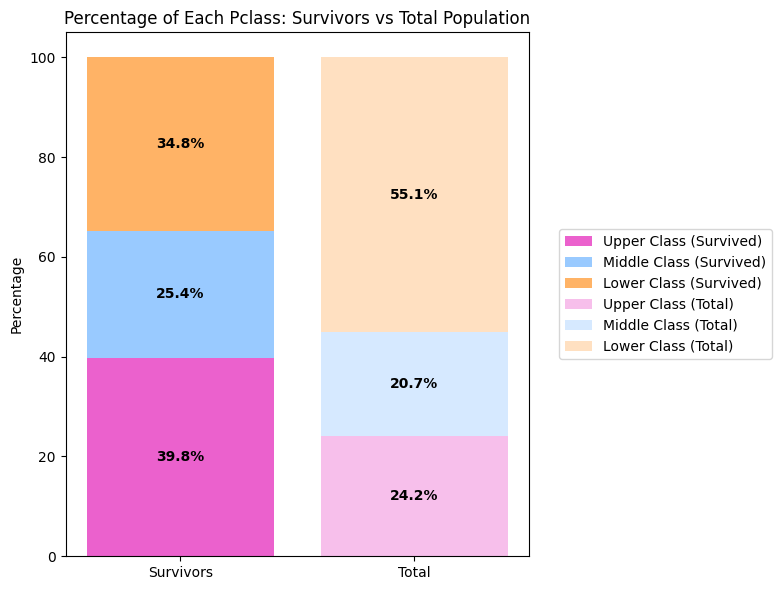

In [14]:
# CLASS DISPROPRTION IN SURVIVORS

# Calculate percentages for survivors
survivors = titanic_df[titanic_df["Survived"] == 1]
surv_counts = survivors["Pclass"].value_counts()
surv_total = surv_counts.sum()
surv_percentages = (surv_counts / surv_total * 100).round(1)
surv_values = [
    surv_percentages.get(label, 0)
    for label in ["Upper Class", "Middle Class", "Lower Class"]
]

# Calculate percentages for total population
total_counts = titanic_df["Pclass"].value_counts()
total_total = total_counts.sum()
total_percentages = (total_counts / total_total * 100).round(1)
total_values = [
    total_percentages.get(label, 0)
    for label in ["Upper Class", "Middle Class", "Lower Class"]
]

fig, ax = plt.subplots(figsize=(8, 6))  # Wider figure

# Stacked bar for survivors
ax.bar("Survivors", surv_values[0], label="Upper Class (Survived)", color="#eb61cd")
ax.bar(
    "Survivors",
    surv_values[1],
    bottom=surv_values[0],
    label="Middle Class (Survived)",
    color="#99caff",
)
ax.bar(
    "Survivors",
    surv_values[2],
    bottom=surv_values[0] + surv_values[1],
    label="Lower Class (Survived)",
    color="#ffb366",
)

# Stacked bar for total population
ax.bar(
    "Total", total_values[0], label="Upper Class (Total)", color="#eb61cd", alpha=0.4
)
ax.bar(
    "Total",
    total_values[1],
    bottom=total_values[0],
    label="Middle Class (Total)",
    color="#99caff",
    alpha=0.4,
)
ax.bar(
    "Total",
    total_values[2],
    bottom=total_values[0] + total_values[1],
    label="Lower Class (Total)",
    color="#ffb366",
    alpha=0.4,
)

ax.set_ylabel("Percentage")
ax.set_title("Percentage of Each Pclass: Survivors vs Total Population")
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))  # Move legend further right
for index, value in enumerate(surv_values):
    ax.text(
        0,
        sum(surv_values[:index]) + value / 2,
        f"{value:.1f}%",
        ha="center",
        va="center",
        color="black",
        fontweight="bold",
    )
for index, value in enumerate(total_values):
    ax.text(
        1,
        sum(total_values[:index]) + value / 2,
        f"{value:.1f}%",
        ha="center",
        va="center",
        color="black",
        fontweight="bold",
    )
plt.tight_layout()
plt.show()

This shows that while the upper class made up 24.2% of the total population, they made up nearly 40% of the survivors. This is a 64% increase in their proportion. Similarly, the middle class group also had a a higher survival proprtion, going up from 20.7% to 25.4%. This is a 22.7% increase.

It's very clear that the higher the class, the higher your chance of surviving was.

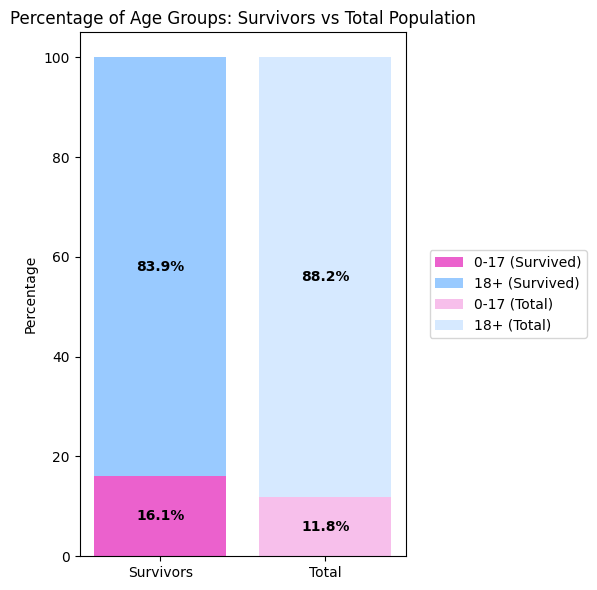

In [15]:
# AGE DISPROPRTION IN SURVIVORS
# Create age group column: 0-18 and 19+
titanic_df["AgeGroup2"] = pd.cut(
    titanic_df["Age"],
    bins=[0, 17, titanic_df["Age"].max() + 1],
    labels=["0-17", "18+"],
    right=False,
)

# Percentage of total survivors by age group (stacked bar chart)
survivors = titanic_df[titanic_df["Survived"] == 1]
age_counts_surv = survivors["AgeGroup2"].value_counts()
total_survivors = age_counts_surv.sum()
percentages_surv = (age_counts_surv / total_survivors * 100).round(1)
values_surv = [percentages_surv.get("0-17", 0), percentages_surv.get("18+", 0)]

# Percentage of total population by age group
age_counts_total = titanic_df["AgeGroup2"].value_counts()
total_population = age_counts_total.sum()
percentages_total = (age_counts_total / total_population * 100).round(1)
values_total = [percentages_total.get("0-17", 0), percentages_total.get("18+", 0)]

fig, ax = plt.subplots(figsize=(6, 6))
# Stacked bar for survivors
ax.bar("Survivors", values_surv[0], label="0-17 (Survived)", color="#eb61cd")
ax.bar(
    "Survivors",
    values_surv[1],
    bottom=values_surv[0],
    label="18+ (Survived)",
    color="#99caff",
)
# Stacked bar for total population
ax.bar("Total", values_total[0], label="0-17 (Total)", color="#eb61cd", alpha=0.4)
ax.bar(
    "Total",
    values_total[1],
    bottom=values_total[0],
    label="18+ (Total)",
    color="#99caff",
    alpha=0.4,
)
ax.set_ylabel("Percentage")
ax.set_title("Percentage of Age Groups: Survivors vs Total Population")
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
for index, value in enumerate(values_surv):
    ax.text(
        0,
        sum(values_surv[:index]) + value / 2,
        f"{value:.1f}%",
        ha="center",
        va="center",
        color="black",
        fontweight="bold",
    )
for index, value in enumerate(values_total):
    ax.text(
        1,
        sum(values_total[:index]) + value / 2,
        f"{value:.1f}%",
        ha="center",
        va="center",
        color="black",
        fontweight="bold",
    )
plt.tight_layout()
plt.show()

Adjusting the grouping to see children vs adults - we see that children aged 17 or under did in fact have an increase in their representation in the surviving group (a 36% increase). Whilst this is still a significant jump, and ceratinly shows they had a higher chance of getting in a lifeboat, it's not quite as steep as some of the other variables tested so far.

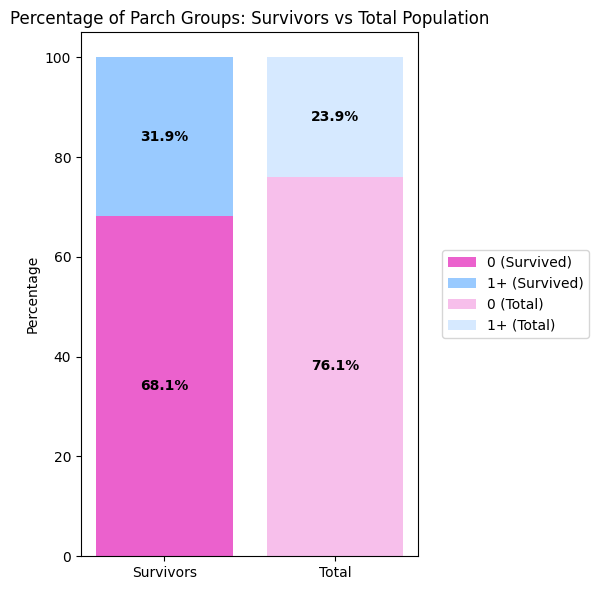

In [16]:
# PARCH DISPROPORTION IN SURVIVORS
# Create Parch group column: 0 and 1+
titanic_df["ParchGroup"] = titanic_df["Parch"].apply(lambda x: "0" if x == 0 else "1+")

# Percentage of total survivors by Parch group (stacked bar chart)
survivors = titanic_df[titanic_df["Survived"] == 1]
parch_counts_surv = survivors["ParchGroup"].value_counts()
total_survivors = parch_counts_surv.sum()
percentages_surv = (parch_counts_surv / total_survivors * 100).round(1)
values_surv = [percentages_surv.get("0", 0), percentages_surv.get("1+", 0)]

# Percentage of total population by Parch group
parch_counts_total = titanic_df["ParchGroup"].value_counts()
total_population = parch_counts_total.sum()
percentages_total = (parch_counts_total / total_population * 100).round(1)
values_total = [percentages_total.get("0", 0), percentages_total.get("1+", 0)]

fig, ax = plt.subplots(figsize=(6, 6))
# Stacked bar for survivors
ax.bar("Survivors", values_surv[0], label="0 (Survived)", color="#eb61cd")
ax.bar(
    "Survivors",
    values_surv[1],
    bottom=values_surv[0],
    label="1+ (Survived)",
    color="#99caff",
)
# Stacked bar for total population
ax.bar("Total", values_total[0], label="0 (Total)", color="#eb61cd", alpha=0.4)
ax.bar(
    "Total",
    values_total[1],
    bottom=values_total[0],
    label="1+ (Total)",
    color="#99caff",
    alpha=0.4,
)
ax.set_ylabel("Percentage")
ax.set_title("Percentage of Parch Groups: Survivors vs Total Population")
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
for index, value in enumerate(values_surv):
    ax.text(
        0,
        sum(values_surv[:index]) + value / 2,
        f"{value:.1f}%",
        ha="center",
        va="center",
        color="black",
        fontweight="bold",
    )
for index, value in enumerate(values_total):
    ax.text(
        1,
        sum(values_total[:index]) + value / 2,
        f"{value:.1f}%",
        ha="center",
        va="center",
        color="black",
        fontweight="bold",
    )
plt.tight_layout()
plt.show()

We also change the grouping of the Parch to see if having any parents or children aboard increases your chance of survival, as opposed to having no parents or children. We see a jump from 23.9% to 31.9% in the surviving population that has at least one parent of child, which represents a 33% increase. Again, that's a significant jump, but not as large as some other variables tested.

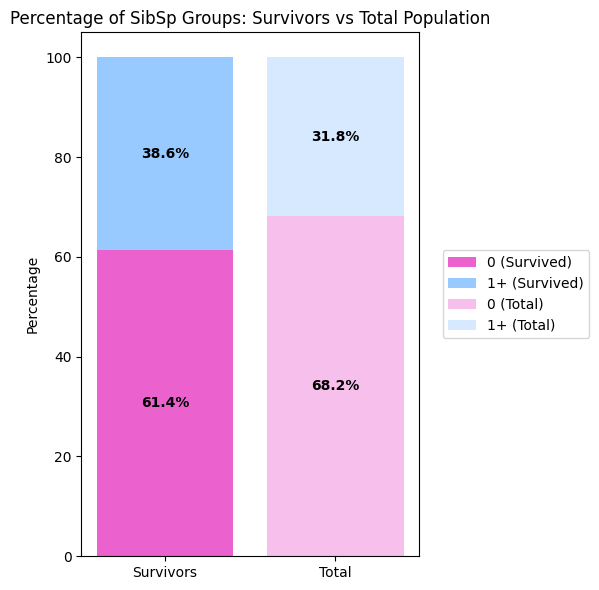

In [17]:
# SibSp DISPROPORTION IN SURVIVORS
# Create SibSp group column: 0 and 1+
titanic_df["SibSpGroup"] = titanic_df["SibSp"].apply(lambda x: "0" if x == 0 else "1+")

# Percentage of total survivors by SibSp group (stacked bar chart)
survivors = titanic_df[titanic_df["Survived"] == 1]
SibSp_counts_surv = survivors["SibSpGroup"].value_counts()
total_survivors = SibSp_counts_surv.sum()
percentages_surv = (SibSp_counts_surv / total_survivors * 100).round(1)
values_surv = [percentages_surv.get("0", 0), percentages_surv.get("1+", 0)]

# Percentage of total population by SibSp group
SibSp_counts_total = titanic_df["SibSpGroup"].value_counts()
total_population = SibSp_counts_total.sum()
percentages_total = (SibSp_counts_total / total_population * 100).round(1)
values_total = [percentages_total.get("0", 0), percentages_total.get("1+", 0)]

fig, ax = plt.subplots(figsize=(6, 6))
# Stacked bar for survivors
ax.bar("Survivors", values_surv[0], label="0 (Survived)", color="#eb61cd")
ax.bar(
    "Survivors",
    values_surv[1],
    bottom=values_surv[0],
    label="1+ (Survived)",
    color="#99caff",
)
# Stacked bar for total population
ax.bar("Total", values_total[0], label="0 (Total)", color="#eb61cd", alpha=0.4)
ax.bar(
    "Total",
    values_total[1],
    bottom=values_total[0],
    label="1+ (Total)",
    color="#99caff",
    alpha=0.4,
)
ax.set_ylabel("Percentage")
ax.set_title("Percentage of SibSp Groups: Survivors vs Total Population")
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
for index, value in enumerate(values_surv):
    ax.text(
        0,
        sum(values_surv[:index]) + value / 2,
        f"{value:.1f}%",
        ha="center",
        va="center",
        color="black",
        fontweight="bold",
    )
for index, value in enumerate(values_total):
    ax.text(
        1,
        sum(values_total[:index]) + value / 2,
        f"{value:.1f}%",
        ha="center",
        va="center",
        color="black",
        fontweight="bold",
    )
plt.tight_layout()
plt.show()

Similarly, we see that having 1 or more Siblings or Spouses on boards walso increased your chance of survival, as opposed to having none. We see a jump from 31.8% to 38.6% in the surviving population that has at least one parent of child, which represents a 21% increase. Again, that's a significant jump, but not as large as some other variables tested.

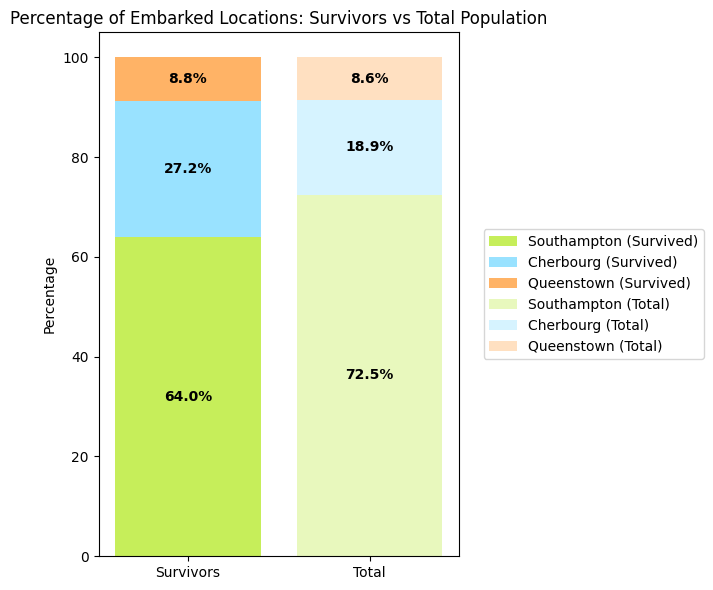

In [18]:
# Embarked vs Survival (stacked bar chart for Embarked locations)
# Ensure Embarked column is mapped to full names before plotting
if titanic_df["Embarked"].isin(["S", "C", "Q"]).any():
    titanic_df["Embarked"] = titanic_df["Embarked"].map(
        {"S": "Southampton", "C": "Cherbourg", "Q": "Queenstown"}
    )

# Assign colors for each Embarked location
embarked_labels = ["Southampton", "Cherbourg", "Queenstown"]
embarked_colors = ["#c6ee5a", "#99e2ff", "#ffb366"]

# Percentage of total survivors by Embarked location
survivors = titanic_df[titanic_df["Survived"] == 1]
embarked_counts_surv = survivors["Embarked"].value_counts()
total_survivors = embarked_counts_surv.sum()
percentages_surv = (
    (embarked_counts_surv / total_survivors * 100)
    .round(1)
)
values_surv = percentages_surv.tolist()

# Percentage of total population by Embarked location
embarked_counts_total = titanic_df["Embarked"].value_counts()
total_population = embarked_counts_total.sum()
percentages_total = (
    (embarked_counts_total / total_population * 100)
    .round(1)
)
values_total = percentages_total.tolist()

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(7, 6))

# Stacked bar for survivors
bottom_surv = 0
# Use zip function to match labels and colors
# For loop to iterate over embarked labels and colors and add to chart
for index, (emb_label, color) in enumerate(zip(embarked_labels, embarked_colors)):
    ax.bar(
        "Survivors",
        values_surv[index],
        bottom=bottom_surv,
        label=f"{emb_label} (Survived)",
        color=color,
    )
    if values_surv[index] > 0:
        ax.text(
            0,
            bottom_surv + values_surv[index] / 2,
            f"{values_surv[index]:.1f}%",
            ha="center",
            va="center",
            color="black",
            fontweight="bold",
        )
    bottom_surv += values_surv[index]

# Stacked bar for total population
bottom_total = 0
for index, (emb_label, color) in enumerate(zip(embarked_labels, embarked_colors)):
    ax.bar(
        "Total",
        values_total[index],
        bottom=bottom_total,
        label=f"{emb_label} (Total)",
        color=color,
        alpha=0.4,
    )
    if values_total[index] > 0:
        ax.text(
            1,
            bottom_total + values_total[index] / 2,
            f"{values_total[index]:.1f}%",
            ha="center",
            va="center",
            color="black",
            fontweight="bold",
        )
    bottom_total += values_total[index]

# Set labels and title
ax.set_ylabel("Percentage")
ax.set_title("Percentage of Embarked Locations: Survivors vs Total Population")
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
plt.show()

Here we see that people that got on at Queenstown had the same proportion in each survived and total, whereas Cherbourg had a 46% increase in survival proportion. We also see that Southamption at the highest share of people on the boat, and they experienced a 12% dip in proprtion. I suspect that the class proportion in each of the boarding groups may have something to do with this representation.

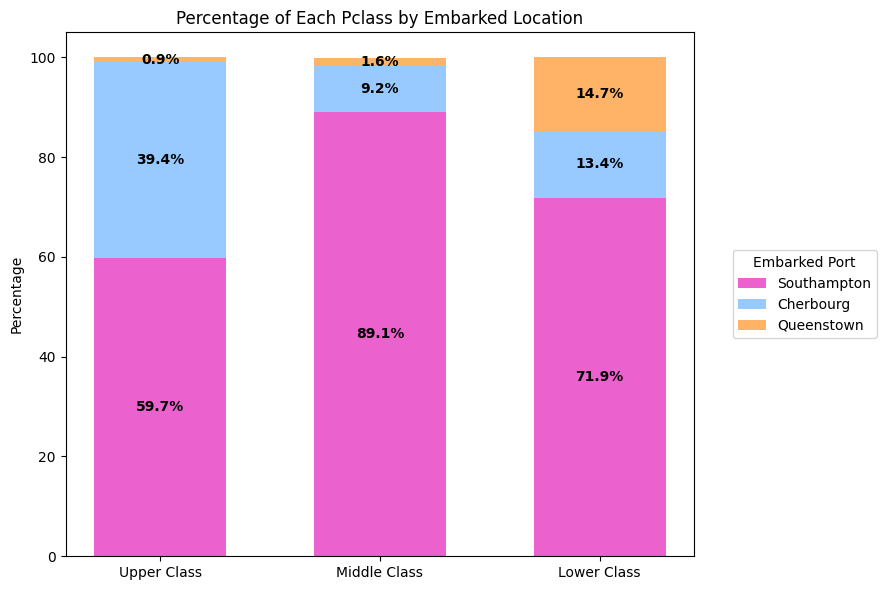

In [19]:
# Stacked bar charts: percentage of each Pclass by Embarked location
pclass_labels = ["Upper Class", "Middle Class", "Lower Class"]
pclass_map = {1: "Upper Class", 2: "Middle Class", 3: "Lower Class"}
embarked_labels = ["Southampton", "Cherbourg", "Queenstown"]
embarked_colors = ["#eb61cd", "#99caff", "#ffb366"]

# Ensure Pclass is mapped to labels
if titanic_df["Pclass"].dtype != object:
    titanic_df["Pclass"] = titanic_df["Pclass"].map(pclass_map)

fig, ax = plt.subplots(figsize=(9, 6))
bar_width = 0.6
x_positions = np.arange(len(pclass_labels))

for i, (emb_label, color) in enumerate(zip(embarked_labels, embarked_colors)):
    percentages = []
    for pclass in pclass_labels:
        group = titanic_df[titanic_df["Pclass"] == pclass]
        total = len(group)
        count = (group["Embarked"] == emb_label).sum()
        percent = (count / total * 100) if total > 0 else 0
        percentages.append(round(percent, 1))
    if i == 0:
        bottoms = np.zeros(len(pclass_labels))
    ax.bar(
        x_positions,
        percentages,
        bar_width,
        bottom=bottoms,
        label=emb_label,
        color=color,
    )
    # Annotate percentages
    for j, pct in enumerate(percentages):
        if pct > 0:
            ax.text(
                x_positions[j],
                bottoms[j] + pct / 2,
                f"{pct:.1f}%",
                ha="center",
                va="center",
                color="black",
                fontweight="bold",
            )
    bottoms += np.array(percentages)

ax.set_xticks(x_positions)
ax.set_xticklabels(pclass_labels)
ax.set_ylabel("Percentage")
ax.set_title("Percentage of Each Pclass by Embarked Location")
ax.legend(title="Embarked Port", loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
plt.show()

Here we find an explanation for the effect that boarding had on the survival rate. With Cherbourg having a large representation in the Upper Class, their positive survival rate follow the assumption that upper class members had better access to lifeboats. Southampton's drop in survival representation is indicative of their dominance in the middle and lower class representation. However, this could've simply been because it was the departure point, and a lot of people would have travelled to get on there from various places in England.

We return to the guiding questions for our EDA.

1. What is the most important factor in determining whether a person was likely to survive the sinking of the Titanic?
2. In the movie, the upper-class passengers were given preference on lifeboats. Does this show in the data?
3. “Women and children first”. Was this the case?
4. Add one other observation that you have noted in the dataset.

1a - Whilst more investigation is needed, we saw that women had the highest increased rate of disproportion in the surviving population. The 91.5% increase lends very strongly to the idea that simply being female led to a much higher chance of getting on a lifeboat.

2a. Yes, it does appear as though upper-class passengers were given the preference in the lifeboats. They had a 64% better representation in the surviving population than the non-surviving population, which gives reason to believe they had better lifeboat access

3a. "Women and children first" is supported - answer 1a shows women were given preferential treatment, and the age stacked bar chart saw a 36% increase in representation for children in the survived population.

4a. Another interesting observation was the median age of each class, with the median and mean age of the loewr and middle class falling into the age categories that had the lowest survival percentage. It could mean that amongst adults, age had no bearing on survival, rather class did.

It was also interesting to note the percentage of each class that was made of each embarkment location. It provided an interesting insight into the class level of different areas, with Cherbourg most likely being a higher-class area.
